# Automatic Stock Picking

## Low Frequency Stock Trading Algorithm
 * Stock picking using annual stock return and accounting characteristics (Factors)
 * Creating Mean Variance Efficient portfolio using Elastic Net Shrikage (Combination of Ridge and Lasso)
 * In sample data: 1980 - 2004
 * Out of sample data: 2005 - 2015 (to verify the portfolio performance)


In [171]:
options(warn=-1)
if (!require(ggplot2)) install.packages("ggplot2")
if (!require(data.table)) install.packages("data.table")
if (!require(foreign)) install.packages("foreign")
if (!require(lfe)) install.packages("lfe")
if (!require(glmnet)) install.packages("glmnet")
if (!require(Metrics)) install.packages("Metrics")
suppressWarnings(suppressMessages(if (!require(Kable)) install.packages("Kable")))
suppressWarnings(suppressMessages(if (!require(expss)) install.packages("expss")))
                                  

## Data Set

In [172]:
setwd('D:/MFE/Curriculum/Fall 2018/Machine Learning/PS4')
StockRetAcct_DT = as.data.table(read.dta("StockRetAcct_insample.dta"))

In [173]:
head(StockRetAcct_DT)

FirmID,year,lnAnnRet,lnRf,MEwt,lnIssue,lnMom,lnME,lnProf,lnEP,lnInv,lnLever,lnROE,rv,lnBM,ff_ind
6,1980,0.3636313,0.07894428,2.814308e-04,0.03134417,0.07535515,12.58147,0.2017671,0.14641121,0.09362611,0.6960014,0.09529421,0.08413413,0.6333913,3
6,1981,-0.2904088,0.13019902,3.214631e-04,0.04421350,0.51265192,12.90800,0.2156609,0.10255504,0.08724214,0.7098430,0.08217967,0.05638131,0.3567226,3
6,1982,0.1866300,0.13070259,2.663127e-04,-0.06819496,-0.22050542,12.55777,0.1840875,0.11954752,0.11166344,0.7309716,0.07951558,0.06207170,0.7794052,3
6,1983,0.4898190,0.08983046,1.699149e-04,-0.07177968,0.04621762,12.56195,0.1655312,0.11592383,-0.03311720,0.7108847,0.05537406,0.07695480,0.7021134,3
10,1991,-0.5080047,0.06121579,3.269729e-05,0.11520413,1.34105313,11.56583,0.2397878,0.02314729,0.30005118,0.4187644,0.14682838,0.37436786,-2.1609421,10
12,2000,-1.3568472,0.06197736,1.219181e-05,0.16523764,0.25174579,12.27575,-0.3823268,-0.02378274,-0.17460629,0.8244712,-0.59177256,1.06719565,-3.8155227,6


### Cleaning the Data

 * Firm Level Characteristics to be used: lnIssue, lnProf, lnInv, and lnME
 * Square of these variable named as lnProf2 = lnProf^2 
 * Intersection terms with Market Equity e.g. lnProf_ME = lnProf * lnME 

In [174]:
StockRetAcct_DT[, `:=`(ExRet, exp(lnAnnRet) - exp(lnRf))]
StockRetAcct_DT = StockRetAcct_DT[, .(FirmID, year, ExRet, ff_ind, MEwt, lnIssue,
lnProf, lnInv, lnME)]

In [175]:
## Toking relevant columns only
head(StockRetAcct_DT)

FirmID,year,ExRet,ff_ind,MEwt,lnIssue,lnProf,lnInv,lnME
6,1980,0.3563997,3,2.814308e-04,0.03134417,0.2017671,0.09362611,12.58147
6,1981,-0.3910973,3,3.214631e-04,0.04421350,0.2156609,0.08724214,12.90800
6,1982,0.0655525,3,2.663127e-04,-0.06819496,0.1840875,0.11166344,12.55777
6,1983,0.5380321,3,1.699149e-04,-0.07177968,0.1655312,-0.03311720,12.56195
10,1991,-0.4614334,10,3.269729e-05,0.11520413,0.2397878,0.30005118,11.56583
12,2000,-0.8064670,6,1.219181e-05,0.16523764,-0.3823268,-0.17460629,12.27575


In [176]:
# Creating squared variables
list_of_squared = colnames(StockRetAcct_DT)[-(1:5)]
for (i in list_of_squared) {
    StockRetAcct_DT[, `:=`(paste0(i, "2"), get(i)^2)]
}

In [177]:
# Creating interaction with ME variable
for (i in list_of_squared[-4]) {
    StockRetAcct_DT[, `:=`(paste0(i, "_ME"), get(i) * lnME)]
}

In [178]:
# Creating a constant
StockRetAcct_DT[, `:=`(Constant, 1)]

In [179]:
head(StockRetAcct_DT)

FirmID,year,ExRet,ff_ind,MEwt,lnIssue,lnProf,lnInv,lnME,lnIssue2,lnProf2,lnInv2,lnME2,lnIssue_ME,lnProf_ME,lnInv_ME,Constant
6,1980,0.3563997,3,2.814308e-04,0.03134417,0.2017671,0.09362611,12.58147,0.0009824569,0.04070995,0.008765849,158.2934,0.3943558,2.538527,1.1779543,1
6,1981,-0.3910973,3,3.214631e-04,0.04421350,0.2156609,0.08724214,12.90800,0.0019548332,0.04650962,0.007611191,166.6164,0.5707076,2.783750,1.1261212,1
6,1982,0.0655525,3,2.663127e-04,-0.06819496,0.1840875,0.11166344,12.55777,0.0046505530,0.03388820,0.012468723,157.6977,-0.8563770,2.311729,1.4022443,1
6,1983,0.5380321,3,1.699149e-04,-0.07177968,0.1655312,-0.03311720,12.56195,0.0051523219,0.02740059,0.001096749,157.8027,-0.9016930,2.079396,-0.4160168,1
10,1991,-0.4614334,10,3.269729e-05,0.11520413,0.2397878,0.30005118,11.56583,0.0132719906,0.05749820,0.090030712,133.7685,1.3324315,2.773345,3.4703413,1
12,2000,-0.8064670,6,1.219181e-05,0.16523764,-0.3823268,-0.17460629,12.27575,0.0273034761,0.14617375,0.030487358,150.6941,2.0284166,-4.693349,-2.1434239,1


### Cross-sectionally demeaning each of the 11 characteristics
lnIssue,	lnProf,	lnInv,	lnME,	lnIssue2,	lnProf2,	lnInv2,	lnME2,	lnIssue_ME,	lnProf_ME,	lnInv_ME

In [180]:
# Identifying and removing NA observations
standardized_StockRetAcct_DT = copy(StockRetAcct_DT)
for (i in colnames(standardized_StockRetAcct_DT)[-1]) {
    standardized_StockRetAcct_DT = standardized_StockRetAcct_DT[!is.na(get(i))]
}

In [181]:
# Creating demeaned dataset
for (i in colnames(standardized_StockRetAcct_DT)[-c(1:5, 17)]) {
    standardized_StockRetAcct_DT[, `:=`(paste0(i), (get(i) - mean(get(i)))),
    by = year]
}

In [182]:
# Marking sample to be used for estimation
standardized_StockRetAcct_DT[, `:=`(Training_data, year <= 2004)]

## Creating Factor Portfolio

In [183]:
# Factor portfolios
N_factors = ncol(standardized_StockRetAcct_DT) - 6
Factor_matrix = matrix(NA, nrow = length(unique(standardized_StockRetAcct_DT$year)),
ncol = N_factors)

for (i in sort(unique(standardized_StockRetAcct_DT$year))) {
    Factor_matrix[(i - 1979), 1:N_factors] = t(data.matrix(standardized_StockRetAcct_DT[year ==
    i, -c("FirmID", "year", "ExRet", "ff_ind", "MEwt", "Training_data")])) %*%
    data.matrix(standardized_StockRetAcct_DT[year == i, .(ExRet)])
}

colnames(Factor_matrix) = colnames(standardized_StockRetAcct_DT[, -c("FirmID", "year", "ExRet", "ff_ind", "MEwt", "Training_data")])
rownames(Factor_matrix) = sort(unique(standardized_StockRetAcct_DT$year))

## Factor sample means and sample variance-covariance matrix

In [184]:
Factor_avg_ret = colMeans(Factor_matrix[1:25, 1:N_factors])
Factor_avg_ret

lnIssue      lnProf       lnInv        lnME    lnIssue2     lnProf2 
 -11.214723   13.299770  -16.991948  -10.565218   -9.202694   -9.971779 
     lnInv2       lnME2  lnIssue_ME   lnProf_ME    lnInv_ME    Constant 
 -22.827767 -290.790558 -152.064519  172.201583 -234.065558  166.326097

In [185]:
Factor_var_matrix = var(Factor_matrix[1:25, 1:N_factors])
Factor_var_matrix

,lnIssue,lnProf,lnInv,lnME,lnIssue2,lnProf2,lnInv2,lnME2,lnIssue_ME,lnProf_ME,lnInv_ME,Constant
lnIssue,640.7192,-994.5461,624.9896,496.1655,352.6523,1383.7085,953.7910,15354.38,8972.693,-13410.777,9344.948,1840.1187
lnProf,-994.5461,2071.3625,-868.2150,-1949.0740,-474.5086,-2983.0591,-1443.2588,-58530.06,-14087.288,27638.292,-13498.771,-369.8943
lnInv,624.9896,-868.2150,880.9365,742.7593,360.2347,1141.9666,1297.8309,22918.90,8842.019,-11712.530,12897.044,2591.4172
lnME,496.1655,-1949.0740,742.7593,10435.7774,203.9477,3028.4673,1424.3177,297633.47,8364.679,-24172.125,13392.404,-9846.1339
lnIssue2,352.6523,-474.5086,360.2347,203.9477,269.9992,683.3212,565.2194,6705.93,4920.633,-6387.321,5344.237,1285.0342
lnProf2,1383.7085,-2983.0591,1141.9666,3028.4673,683.3212,4495.3851,1903.9075,91094.52,19584.810,-39726.708,17889.251,165.9178
lnInv2,953.7910,-1443.2588,1297.8309,1424.3177,565.2194,1903.9075,1987.7943,43495.22,13565.461,-19397.242,19207.827,3246.0576
lnME2,15354.3826,-58530.0579,22918.9028,297633.4683,6705.9302,91094.5206,43495.2240,8522765.40,255411.705,-729700.060,407897.759,-255818.1326
lnIssue_ME,8972.6926,-14087.2883,8842.0190,8364.6787,4920.6331,19584.8101,13565.4613,255411.71,125976.333,-189731.988,132615.849,24152.4486
lnProf_ME,-13410.7773,27638.2922,-11712.5300,-24172.1252,-6387.3214,-39726.7085,-19397.2416,-729700.06,-189731.988,369318.567,-181628.915,-8014.2557


In [186]:
Factor_sharpe = colMeans(Factor_matrix[1:25, 1:N_factors])/(diag(var(Factor_matrix[1:25,
1:N_factors]))^0.5)

Factor_sharpe

lnIssue      lnProf       lnInv        lnME    lnIssue2     lnProf2 
-0.44305199  0.29222414 -0.57249390 -0.10342274 -0.56005894 -0.14872679 
     lnInv2       lnME2  lnIssue_ME   lnProf_ME    lnInv_ME    Constant 
-0.51200914 -0.09960704 -0.42843349  0.28335871 -0.53704364  0.55753938

## Using Elastic Net regularization (which uses  Ridge and Lasso) to find the coefficient of factors

In [187]:
# Running 5 seperate elastic net regressions
#sample factor averages and sample factor covariance matrix in a 20-year subperiod

in_sample_Factor_matrix = Factor_matrix[1:25, 1:N_factors]

for (i in 1:5) {
    # Defininng sample
    # sample factor averages and sample factor covariance matrix in a 20-year subperiod
    Factor_sample_avg_ret = colMeans(in_sample_Factor_matrix[-((5 * (i - 1) + 1):(5 * i)), ])
    Factor_sample_var_matrix = var(in_sample_Factor_matrix[-((5 * (i - 1) + 1):(5 * i)), ])
    
    # Running elastic net
    assign(paste0("Elastic_net_", i), glmnet(Factor_sample_var_matrix, Factor_sample_avg_ret, 
                                             family = "gaussian", alpha = 0.5, standardize = TRUE))
    
    # Defining a range of lambdas
    if (i == 1) {
        S_min = min(Elastic_net_1$lambda)
        S_max = max(Elastic_net_1$lambda)
    } else {
        S_min = min(S_min, get(paste0("Elastic_net_", i))$lambda)
        S_max = max(S_max, get(paste0("Elastic_net_", i))$lambda)
    }
}


# Predicting factor returns and compare; mse is part of the Metrics package
range_of_lambda = seq(S_min - 1, S_max + 1, 0.01)
MSE_lambda = matrix(NA, nrow = 6, ncol = length(range_of_lambda))
for (i in 1:5) {
    b_matrix = as.matrix(predict(get(paste0("Elastic_net_", i)), type = "coef", s = range_of_lambda))[-1, ]
        for (j in 1:length(range_of_lambda)) {
            MSE_lambda[i, j] = mse(b_matrix[, j] %*% var(in_sample_Factor_matrix[(5 * 
                                (i - 1) + 1):(5 * i), ]), colMeans(in_sample_Factor_matrix[(5 * (i - 1) + 1):(5 * i), ]))
        }
}


MSE_lambda[6, ] = colMeans(MSE_lambda[1:5, ])

Best_lambda = range_of_lambda[which(MSE_lambda[6, ] == min(MSE_lambda[6, ]), arr.ind = TRUE)]

Best_lambda

[1] 22.38716

In [188]:
# Calculating b_vector for Best_lambda
b_vector = glmnet(Factor_var_matrix, Factor_avg_ret, family = "gaussian", alpha = 0.5,
standardize = TRUE, lambda = Best_lambda)$beta
b_vector

12 x 1 sparse Matrix of class "dgCMatrix"
                      s0
lnIssue    -2.751982e-03
lnProf      .           
lnInv      -2.602896e-03
lnME        .           
lnIssue2   -8.773452e-03
lnProf2     .           
lnInv2     -4.786693e-04
lnME2       .           
lnIssue_ME -1.262971e-04
lnProf_ME   .           
lnInv_ME   -6.702161e-05
Constant    1.964595e-04

### With the final b-vector in hand, calculating the out-of-sample average return, standard deviation, and Sharpe ratio for the corresponding estimated “ex ante” MVE portfolio with return b’F_t in the period 2005-2014.

In [189]:
b_vector = data.matrix(b_vector)
Out_of_sample_ret = Factor_matrix[-(1:25), ] %*% b_vector
mean(Out_of_sample_ret) # Mean

[1] 0.06117857

In [190]:
sd(Out_of_sample_ret) #Standard deviation

[1] 0.09430877

In [191]:
mean(Out_of_sample_ret)/sd(Out_of_sample_ret) # Sharpe ratio

[1] 0.648705

### Plotting cumulative return on this portfolio relative to that on the market (market return using the value-weights in the sample, MEwt) over the 2005-2014 period

In [192]:
for (i in colnames(StockRetAcct_DT)[-(1)]) {
    StockRetAcct_DT = StockRetAcct_DT[!is.na(get(i))]
}

# Calculating 'market' return
StockRetAcct_DT[, `:=`(MEwt_adj, MEwt/sum(MEwt)), by = year]

MktRet = StockRetAcct_DT[year > 2004, .(Mkt_Ret = sum(ExRet * MEwt_adj)), by = year]

setorder(MktRet, year)

mean(MktRet$Mkt_Ret) # Mean

[1] 0.08122235

In [193]:
sd(MktRet$Mkt_Ret) # Standard deviation

[1] 0.1831969

In [194]:
mean(MktRet$Mkt_Ret)/sd(MktRet$Mkt_Ret) # Sharpe ratio

[1] 0.443361

In [195]:
# Scaling MVE portfolio to match market
Scaled_Out_of_sample_ret = data.table(Out_of_sample_ret * sd(MktRet$Mkt_Ret)/sd(Out_of_sample_ret))
setnames(Scaled_Out_of_sample_ret, "s0", "Elastic_Ret")

In [196]:
# Calculating cumulative returns
Scaled_Out_of_sample_ret[, `:=`(Cum_Ret, cumprod(1 + Elastic_Ret))]
MktRet[, `:=`(Cum_Ret, cumprod(1 + Mkt_Ret))]

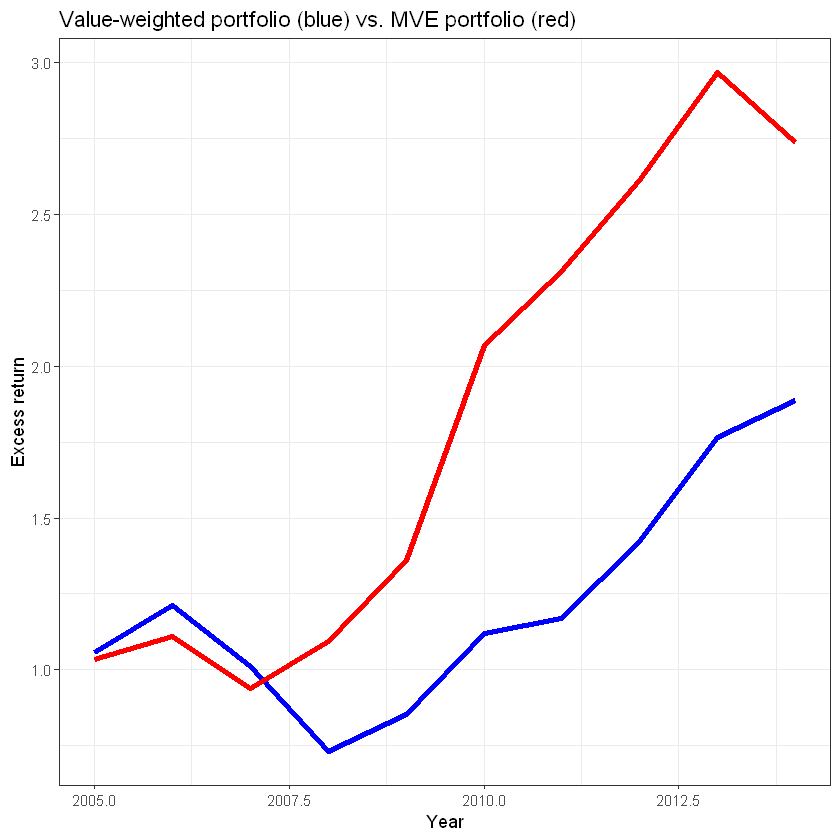

In [197]:
# Plot
p = qplot(MktRet$year, MktRet$Cum_Ret, geom = "line", xlab = "Year", ylab = "Excess return", 
      color = I("blue"), size = I(1.5), main = "Value-weighted portfolio (blue) vs. MVE portfolio (red)") 

p+geom_line(aes(y = Scaled_Out_of_sample_ret$Cum_Ret), color = I("red"), size = I(1.5)) +
theme_bw()